## MBTA Weekday Trip and Ridership Comparison


This program compares service and ridership across weekdays for the MBTA
transit network. 

It takes the following inputs:
1) A compliant GTFS feed and

2) A table of ridership data exported from the ODX origin-destination-transfer inference system, which is also an input to the ROVE Map.


The output is a CSV table and set of charts that quantify and visualize the
match between service and ridership for each weekday for different time
periods.

Nick Caros, MIT Transit Lab, July 2021

In [1]:
# Load the data processing packages
import partridge as ptg
import pandas as pd
import datetime

### First, import data and compute trip, boarding totals

In [2]:
# Define user inputs
gtfs_inpath = 'data/mbta_gtfs_oct2019.zip'
ridership_inpath = 'data/mbta_records_oct2019_odx.p'

time_periods = {"Sunrise (3AM-6AM)" : [3, 6],
                "Early AM (6AM-7AM)" : [6, 7],
                "AM Peak (7AM-9AM)" : [7, 9],
                "Mid-day Base (9AM-1:30PM)" : [9, 13.5],
                "Mid-day School (1:30PM-4PM)" : [13.5, 16],
                "PM Peak (4PM-6:30PM)" : [16, 18.5],
                "Evening (6:30PM-10PM)" : [18.5, 22],
                "Late Evening (10PM-12AM)" : [22, 24],
                "Night (12AM-2AM)" : [24, 26],
                }

# Monday of a typical week in the data period
typical_mon = datetime.date(2019, 10, 21)

Start with counting trips from GTFS

In [3]:
# Import GTFS feed for each day and filter out special routes
route_type = ['0', '1', '3']
route_desc = ['Rapid Transit','Key Bus', 'Commuter Bus', 'Local Bus']
feed_list = []
service_ids = ptg.read_service_ids_by_date(gtfs_inpath)
for weekday in range(5):
    day = typical_mon + datetime.timedelta(days=weekday)
    daily_service = service_ids[day]
    view = {'routes.txt': {'route_type': route_type, 'route_desc': route_desc}, 'trips.txt': {'service_id': daily_service}}
    feed = ptg.load_feed(gtfs_inpath, view)
    feed_list.append(feed)

In [4]:
# Arrange time periods into bins
bin_range = [0]
for period in time_periods:
    bin_range.append(int(time_periods[period][1] * 3600))

print(bin_range)

[0, 21600, 25200, 32400, 48600, 57600, 66600, 79200, 86400, 93600]


In [5]:
# Find avg. number of trips per period, per weekday, per route
trips_dict = {}
day_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
for index, feed in enumerate(feed_list):
    
    # Import trips as df
    trips = feed.trips[['route_id', 'trip_id']]
    
    # Get trip start time and append to trip df
    trip_start = feed.stop_times[['trip_id', 'arrival_time', 'stop_sequence']]
    trip_start = trip_start.groupby(['trip_id'], as_index=False).agg({'stop_sequence': 'min', 'arrival_time': 'first'})
    trip_start = trip_start[['trip_id', 'arrival_time']]
    trips = pd.merge(trips, trip_start, on='trip_id')[['route_id', 'arrival_time']]

    # Group by route, time period
    trips = trips.groupby(['route_id', pd.cut(trips.arrival_time, bin_range, labels=time_periods.keys())]).count()
    trips_dict[day_list[index]] = trips.groupby(level=0).apply(lambda trips: trips.xs(trips.name)['arrival_time'].to_dict()).to_dict()

# Add full day total for each route
for day in trips_dict:
    for route in trips_dict[day]:
        total = 0
        for period in trips_dict[day][route]:
            total += trips_dict[day][route][period]
        trips_dict[day][route]['Full Day'] = total

trips_dict['Monday']['1']

{'Sunrise (3AM-6AM)': 12.0,
 'Early AM (6AM-7AM)': 15.0,
 'AM Peak (7AM-9AM)': 32.0,
 'Mid-day Base (9AM-1:30PM)': 54.0,
 'Mid-day School (1:30PM-4PM)': 32.0,
 'PM Peak (4PM-6:30PM)': 40.0,
 'Evening (6:30PM-10PM)': 45.0,
 'Late Evening (10PM-12AM)': 18.0,
 'Night (12AM-2AM)': 10.0,
 'Full Day': 258.0}

Next, count boardings from ODX

In [6]:
# Import ridership data and remove records with no boards
ridership_df = pd.read_pickle(ridership_inpath)[['route', 'stop_time', 'passenger_on']]
ridership_df = ridership_df[ridership_df['passenger_on'] > 0]

# Split arrival time into day of week and seconds
ridership_df['stop_time'] = pd.to_datetime(ridership_df['stop_time'])
ridership_df['weekday'] = ridership_df['stop_time'].dt.dayofweek
ridership_df['arrival_time'] = ridership_df['stop_time'].dt.hour * 3600 + ridership_df['stop_time'].dt.minute * 60 + ridership_df['stop_time'].dt.second
ridership_df = ridership_df[['weekday', 'route', 'arrival_time']]

ridership_df.head()

,weekday,route,arrival_time
0,2,62,22911
1,1,62,22976
3,3,62,22427
4,1,62,22976
5,4,62,22507


In [7]:
# Make modifications when arrival is after midnight but before next day of service
mod_weekday = []
mod_arrivaltime = []
for record in ridership_df.values.tolist():
    weekday = record[0]
    arrival_time = record[2]
    if arrival_time < 9000:
        mod_weekday.append(day_list[weekday-1])
        mod_arrivaltime.append(arrival_time + 86400)
    else:
        mod_weekday.append(day_list[weekday])
        mod_arrivaltime.append(arrival_time)

ridership_df['weekday'] = mod_weekday
ridership_df['arrival_time'] = mod_arrivaltime

# Convert route id to string for consistency with trip dict
ridership_df['route'] = ridership_df['route'].apply(str)

ridership_df.head()

,weekday,route,arrival_time
0,Wednesday,62,22911
1,Tuesday,62,22976
3,Thursday,62,22427
4,Tuesday,62,22976
5,Friday,62,22507


In [8]:
# Find avg. number of boardings per period, per weekday, per route
ridership_df = ridership_df.groupby(['weekday', 'route', pd.cut(ridership_df.arrival_time, bin_range, labels=time_periods.keys())]).count()
ridership_df.columns = ['count']
ridership_df = ridership_df.reset_index()
ridership_dict = {}
for day in day_list:
    day_df = ridership_df[ridership_df['weekday'] == day][['route', 'arrival_time', 'count']]
    day_df = day_df.groupby(['route', 'arrival_time']).sum()
    ridership_dict[day] = day_df.groupby(level=0).apply(lambda day_df: day_df.xs(day_df.name)['count'].to_dict()).to_dict()

# Add full day total for each route
for day in ridership_dict:
    for route in ridership_dict[day]:
        total = 0
        for period in ridership_dict[day][route]:
            total += ridership_dict[day][route][period]
        ridership_dict[day][route]['Full Day'] = total 
        
ridership_dict['Monday']['1']

{'Sunrise (3AM-6AM)': 110.0,
 'Early AM (6AM-7AM)': 243.0,
 'AM Peak (7AM-9AM)': 693.0,
 'Mid-day Base (9AM-1:30PM)': 1338.0,
 'Mid-day School (1:30PM-4PM)': 775.0,
 'PM Peak (4PM-6:30PM)': 1026.0,
 'Evening (6:30PM-10PM)': 995.0,
 'Late Evening (10PM-12AM)': 295.0,
 'Night (12AM-2AM)': 84.0,
 'Full Day': 5559.0}

Combine data into a single dictionary

In [9]:
full_dict = {}
for day in trips_dict:
    full_dict[day] = {}
    for route in trips_dict[day]:
        full_dict[day][route] = {}
        for period in trips_dict[day][route]:
            full_dict[day][route][period]={}
            full_dict[day][route][period]['Trips'] = trips_dict[day][route][period]
            try:
                full_dict[day][route][period]['Boardings'] = ridership_dict[day][route][period]
            except KeyError:
                full_dict[day][route][period]['Boardings'] = 0
  
full_dict['Monday']['1']

{'Sunrise (3AM-6AM)': {'Trips': 12.0, 'Boardings': 110.0},
 'Early AM (6AM-7AM)': {'Trips': 15.0, 'Boardings': 243.0},
 'AM Peak (7AM-9AM)': {'Trips': 32.0, 'Boardings': 693.0},
 'Mid-day Base (9AM-1:30PM)': {'Trips': 54.0, 'Boardings': 1338.0},
 'Mid-day School (1:30PM-4PM)': {'Trips': 32.0, 'Boardings': 775.0},
 'PM Peak (4PM-6:30PM)': {'Trips': 40.0, 'Boardings': 1026.0},
 'Evening (6:30PM-10PM)': {'Trips': 45.0, 'Boardings': 995.0},
 'Late Evening (10PM-12AM)': {'Trips': 18.0, 'Boardings': 295.0},
 'Night (12AM-2AM)': {'Trips': 10.0, 'Boardings': 84.0},
 'Full Day': {'Trips': 258.0, 'Boardings': 5559.0}}

Then export full results to CSV

In [10]:
output_df = pd.DataFrame.from_dict({(i,j,k): full_dict[i][j][k] 
                           for i in full_dict.keys() 
                           for j in full_dict[i].keys()
                           for k in full_dict[i][j].keys()},
                       orient='index')

output_df.index.set_names(['Day','Route ID','Time Period'],inplace=True)
output_df.to_csv("results.csv")

### Now, visualize selected results

In [11]:
import matplotlib.pyplot as plt
import numpy as np

Choose a route and time period

In [12]:
selected_route = '1'
selected_period = list(time_periods.keys())[2] # could also use input list to specify, i.e. list(time_periods.keys())[2]

#### First plot: Compare trips and ridership data throughout the week for the selected time period
Lookup trip and ridership data

In [13]:
trip_list = []
boardings_list = []
for day in full_dict:
    data = full_dict[day][selected_route][selected_period]
    trip_list.append(data['Trips'])
    boardings_list.append(data['Boardings'])

Plot using matplotlib

<ipython-input-14-54cda6924202>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


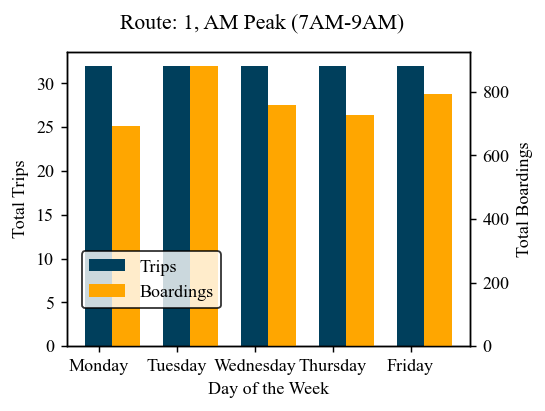

In [14]:
plt.rcParams.update({'font.size': 10})
plt.rcParams["font.family"] = "Times New Roman"
fig, ax1 = plt.subplots(dpi=130,figsize=(4,3))
x1 = np.arange(5)
width = 0.35

ax1.set_xlabel(r'Day of the Week')
ax1.set_ylabel(r'Total Trips')
ax1.bar(x1 - width/2, height = trip_list, tick_label = day_list, label='Trips', color='#003f5c', width = width)
ax1.set_ylim(0) # Force start at 0

ax2 = ax1.twinx()
ax2.set_ylabel('Total Boardings')
ax2.bar(x1 + width/2, height = boardings_list, color='#ffa600', label='Boardings', width = width)
fig.legend(loc=(0.15, 0.25)).get_frame().set_edgecolor('black')
ax2.set_ylim(0) # Force start at 0
fig.suptitle('Route: ' + selected_route + ", " + selected_period)

fig.show()

#### Second plot: compare passengers per trip throughout the day, for each weekday, for the selected route.
Lookup trip and ridership data

In [15]:
y_vals = {}
for day in full_dict:
    daily_list = []
    for period in full_dict[day][selected_route]:
        
        if period == 'Full Day': continue # ignore full day for this plot
        
        trips = full_dict[day][selected_route][period]['Trips']
        boardings = full_dict[day][selected_route][period]['Boardings']
        pax_per_trip = round(boardings/trips,2)
        daily_list.append(pax_per_trip)
    
    y_vals[day] = daily_list
    
print(y_vals)

{'Monday': [9.17, 16.2, 21.66, 24.78, 24.22, 25.65, 22.11, 16.39, 8.4], 'Tuesday': [11.92, 20.53, 27.56, 27.28, 28.25, 30.8, 24.11, 19.33, 6.8], 'Wednesday': [12.5, 18.8, 23.69, 26.06, 28.38, 27.77, 25.76, 18.67, 6.4], 'Thursday': [11.92, 18.6, 22.75, 24.24, 25.66, 27.93, 23.8, 16.78, 7.9], 'Friday': [10.17, 18.53, 24.75, 27.06, 23.5, 23.93, 22.93, 18.56, 8.9]}


Plot using matplotlib

<ipython-input-16-d88cef164b91>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  f2ax1.set_xticklabels(list(time_periods.keys()), rotation = 60, ha = 'right')
<ipython-input-16-d88cef164b91>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


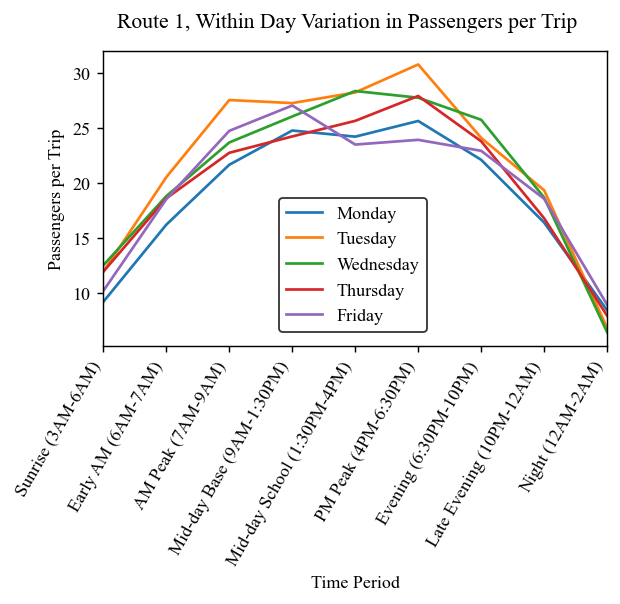

In [16]:
fig2, f2ax1 = plt.subplots(dpi=130,figsize=(5,3))
x2 = np.arange(len(y_vals['Monday']))

f2ax1.set_xlim(0, len(y_vals['Monday'])-1)
f2ax1.set_xlabel(r'Time Period')
f2ax1.set_ylabel(r'Passengers per Trip')

for day in y_vals:
    f2ax1.plot(x2, y_vals[day], label=day)

fig2.legend(loc=(0.45, 0.45)).get_frame().set_edgecolor('black')
fig2.suptitle('Route ' + selected_route + ", Within Day Variation in Passengers per Trip")
f2ax1.set_xticklabels(list(time_periods.keys()), rotation = 60, ha = 'right')

fig2.show()

#### Third plot: compare passengers per trip throughout the day, by garage.
Lookup trip and ridership data

In [17]:
# Get garage assignments for each route
garage_dict = {
    "Albany" : ["4", "55", "57", "59", "60", "65", "66", "170", "193", "501", "502", "503", "504", "505", "553", "554", "556", "558", "708", "747"],
    "Arborway" : ["14", "21", "24", "26", "27", "29", "30", "31", "32", "33", "34", "34E", "35", "36", "37", "38", "39", "40", "41", "42", "50", "51", "52", "192", "195", "2427", "4050"],
    "Cabot" : ["1", "7", "8", "9", "10", "11", "15", "16", "17", "18", "19", "22", "23", "43", "44", "45", "47", "55", "57", "59", "60", "65", "66", "171", "191", "193", "504", "553"],
    "Charlestown" : ["89", "90", "91", "92", "93", "94", "95", "96", "97", "99", "100", "101", "104", "105", "106", "108", "109", "110", "111", "112", "132", "134", "136", "137", "194", "325", "326", "352", "411", "430", "61", "62", "64", "67", "68", "69", "70", "71", "72", "73", "74", "75", "76", "77", "78", "79", "80", "83", "84", "85", "86", "87", "88", "350", "351"],
    "Fellsway" : ["90", "95", "96", "97", "99", "100", "105", "106", "108", "131", "132", "134", "136", "137", "354", "411", "430"],
    "Lynn" : ["114", "116", "117", "119", "120", "121", "424", "426", "428", "429", "434", "435", "436", "439", "441", "442", "450", "451", "455", "456", "465", "441442"],
    "N Cambridge" : ["71", "73", "77A"],
    "Quincy" : ["201", "202", "210", "211", "212", "214", "215", "216", "217", "220", "221", "222", "225", "226", "230", "236", "238", "240", "245", "214216"],
    "Southampton" : ["16", "28", "39", "741", "742", "743", "746", "749", "751"],
    # "Rail" : ["Blue", "Green-B", "Green-C", "Green-D", "Green-E", "Mattapan", "Orange", "Red"]
}

In [18]:
# Rearrange data by garage, day and period
results_dict = {}
for garage in garage_dict:
    garage_results = {}
    for route in garage_dict[garage]:
        for day in day_list:
            if day not in garage_results:
                garage_results[day] = {}
            try:
                for period in full_dict[day][route]:
                    
                    if period == 'Full Day': continue
                    
                    if period in garage_results[day]:
                        trips = full_dict[day][route][period]['Trips']
                        if np.isnan(trips):
                            trips = 0
                        garage_results[day][period]['Trips'] += trips
                        garage_results[day][period]['Boardings'] += full_dict[day][route][period]['Boardings']
                    else:
                        garage_results[day][period] = {}
                        trips = full_dict[day][route][period]['Trips']
                        if np.isnan(trips):
                            trips = 0
                        garage_results[day][period]['Trips'] = trips
                        garage_results[day][period]['Boardings'] = full_dict[day][route][period]['Boardings']
            
            except KeyError:
                continue
    results_dict[garage] = {}
    for day in garage_results:
        garage_list = []
        for period in garage_results[day]:
            trips = garage_results[day][period]['Trips']
            if trips == 0:
                garage_list.append(0)
            else:
                garage_list.append(round(garage_results[day][period]['Boardings']/trips,2))        
        results_dict[garage][day] = garage_list
            

In [19]:
# Set up function to plot a chart for each day comparing the garages
def plot_day(day_name, time_periods, results_dict):
    fig, ax1 = plt.subplots(dpi=110,figsize=(5,3))
    x = np.arange(len(y_vals['Monday']))

    ax1.set_xlim(0, len(y_vals['Monday'])-1)
    ax1.set_xlabel(r'Time Period')
    ax1.set_ylabel(r'Passengers per Trip')
    ax1.set_xticks(x)
    
    for garage in results_dict:
        ax1.plot(x, results_dict[garage][day_name], label=garage)
        fig.suptitle(day_name + " Variation in Passengers per Trip by Garage")
        ax1.set_xticklabels(list(time_periods.keys()), rotation = 60, ha = 'right')

    fig.legend(bbox_to_anchor=(0.92,0.82), loc="upper left").get_frame().set_edgecolor('black')
        

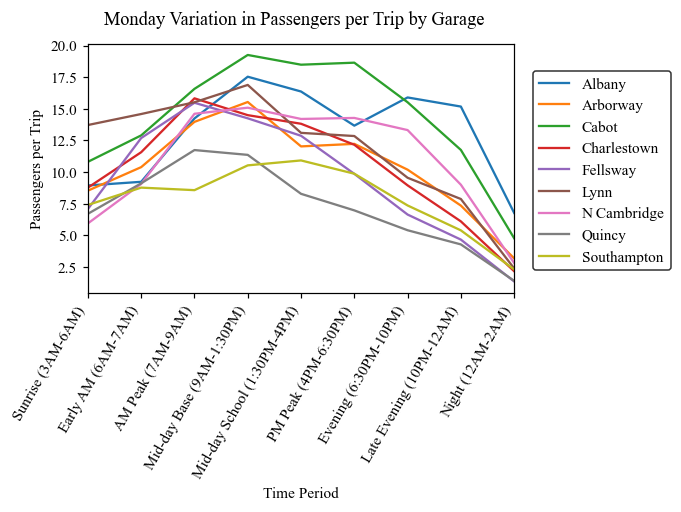

In [20]:
plot_day('Monday', time_periods, results_dict)

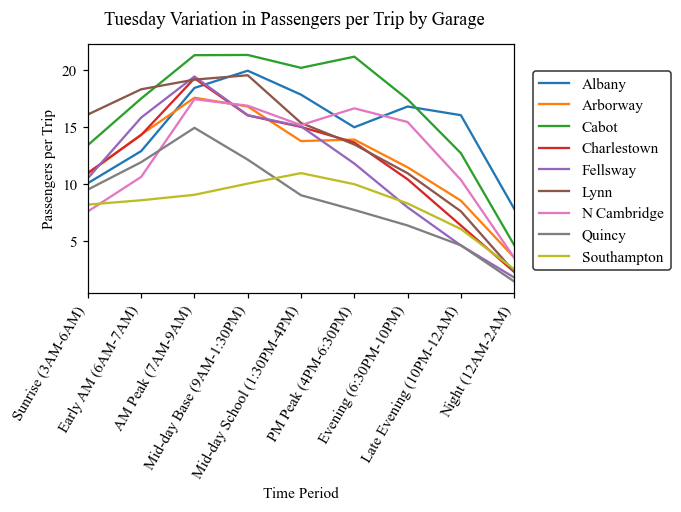

In [21]:
plot_day('Tuesday', time_periods, results_dict)

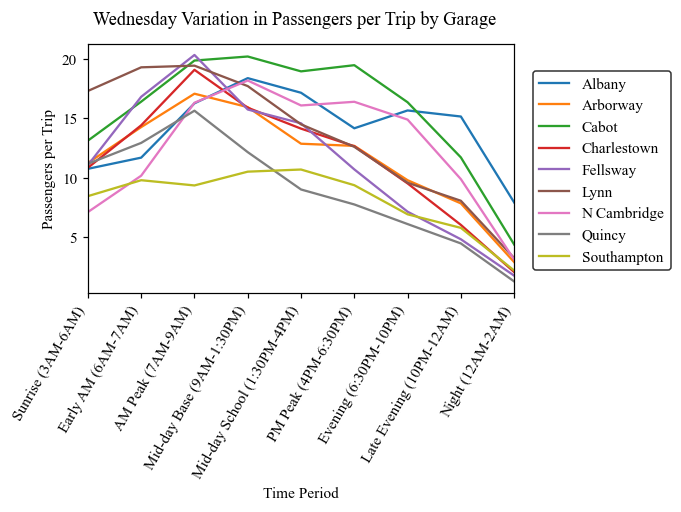

In [22]:
plot_day('Wednesday', time_periods, results_dict)

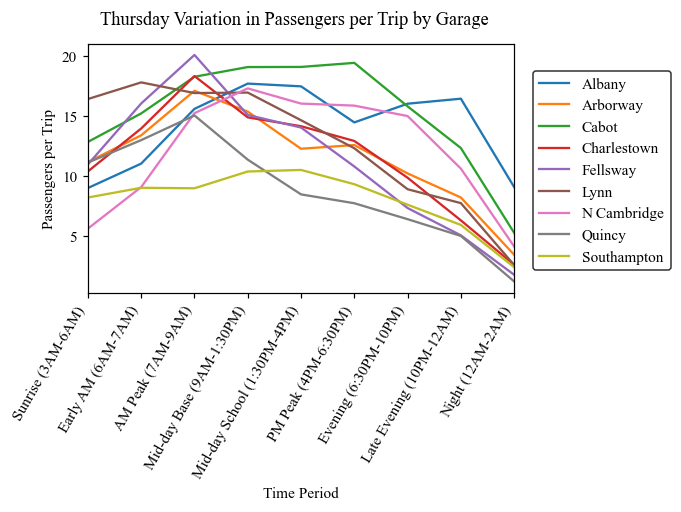

In [23]:
plot_day('Thursday', time_periods, results_dict)

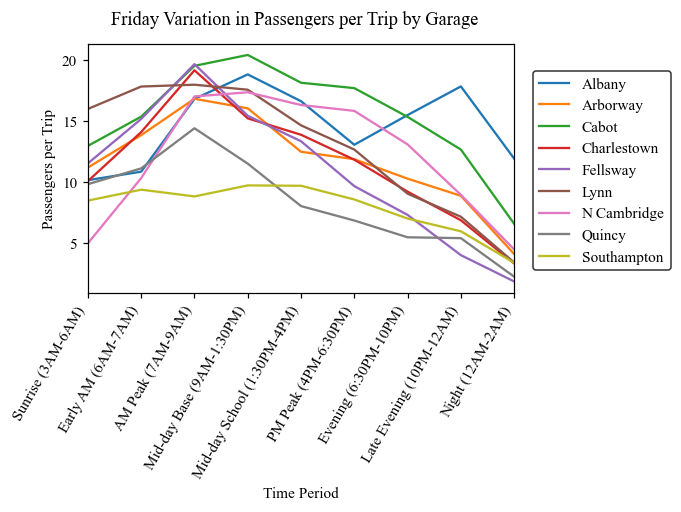

In [24]:
plot_day('Friday', time_periods, results_dict)